In [1]:
import logging
import time

import btk
import galsim
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
import scarlet
import scarlet.psf
import seaborn as sns
import sep
import tensorflow as tf
import tensorflow_probability as tfp

from maddeb.Deblender import Deblend
from maddeb.extraction import extract_cutouts
from maddeb.metrics import (
    compute_apperture_photometry,
    compute_pixel_covariance_and_flux,
)

from maddeb.utils import CustomSampling

2022-09-26 13:41:53.629305: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2022-09-26 13:41:53.629517: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
COSMOS_CATALOG_PATHS = [
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits",
    "/sps/lsst/users/bbiswas/COSMOS_catalog/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2_fits.fits",
]


stamp_size = 45
max_number = 100
batch_size = 1
maxshift = 17
catalog = btk.catalog.CosmosCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("LSST")
seed=3

galsim_catalog = galsim.COSMOSCatalog(COSMOS_CATALOG_PATHS[0], exclusion_level="marginal")

sampling_function = CustomSampling(
    index_range=[60000, 80000], max_number=max_number, maxshift=maxshift, stamp_size=stamp_size, seed=seed
)

draw_generator = btk.draw_blends.CosmosGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    gal_type="parametric",
    seed=seed,
)

In [3]:
blend = next(draw_generator)

Generating blends for LSST survey:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
field_images = blend["blend_images"]
isolated_images = blend["isolated_images"]

# Deblend with Scarlet

In [5]:
np.shape(field_images)

(1, 6, 225, 225)

In [6]:
psf = np.array([p.drawImage(galsim.Image(field_images[0].shape[1],field_images[0].shape[2]),scale=survey.pixel_scale.to_value("arcsec")).array for p in blend["psf"]])
bands=[f for f in survey._filters]
wcs = blend["wcs"]

In [7]:
import scarlet.psf
from scarlet.psf import ImagePSF

In [8]:
def predict_with_scarlet(image, x_pos, y_pos, show_scene, show_sources, filters):
    sig = []
    weights = np.ones_like(image)
    for i in range(6):
        sig.append(sep.Background(image[i]).globalrms)
        weights[i] = weights[i] / (sig[i]**2)
    observation = scarlet.Observation(
            image, psf=scarlet.psf.ImagePSF(psf), weights= weights, channels=bands, wcs=wcs
        )
    
    model_psf = scarlet.GaussianPSF(sigma=(0.382, .365, .344, .335, .327, .323))
    model_frame = scarlet.Frame(
    image.shape,
    psf=model_psf,
    channels=filters, wcs=wcs)

    
    observation = observation.match(model_frame)
    sources = []
    for i in range(len(x_pos)):
        result = scarlet.ExtendedSource(
            model_frame,
            model_frame.get_sky_coord((x_pos[i], y_pos[i])),
            observation,
            thresh=1,
            shifting=True,
        )
        sources.append(result)

    scarlet.initialization.set_spectra_to_match(sources, observation)
    
    scarlet_blend = scarlet.Blend(sources, observation)
    
    %time it, logL = scarlet_blend.fit(200, e_rel=1e-5)
    #print(f"scarlet ran for {it} iterations to logL = {logL}")
    #scarlet.display.show_likelihood(scarlet_blend)
    #plt.show()
    
    if show_scene:
        scarlet.display.show_scene(sources,
                           norm=None,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True)
        
        plt.show()
    
    if show_sources:
        scarlet.display.show_sources(sources,
                                 norm=None,
                                 observation=observation,
                                 show_rendered=True,
                                 show_observed=True,
                                 add_boxes=True
                                )
        plt.show()
    
    predicted_sources = []
    for src in sources:
        predicted_sources.append(observation.render(src.get_model(frame=model_frame)))
    #print(np.shape(src.get_model(frame=model_frame)))
    return predicted_sources

In [9]:
image = field_images[0]

In [10]:
x_pos = blend['blend_list'][0]['y_peak']
y_pos = blend['blend_list'][0]['x_peak']

In [11]:
#model = predict_with_scarlet(image, x_pos=x_pos, y_pos=y_pos, show_scene=True, show_sources=True, filters=bands)

In [12]:
#plt.imshow(model[0][2])

In [13]:
scarlet_predictions=[]
for i, image in enumerate(field_images):
    image = field_images[i]
    x_pos = blend['blend_list'][i]['y_peak']
    y_pos = blend['blend_list'][i]['x_peak']
    predicted_sources = predict_with_scarlet(image, x_pos=x_pos, y_pos=y_pos, show_scene=False, show_sources=False, filters=bands)
    scarlet_predictions.append(predicted_sources)

Completed 50 iterations and [50, 474, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 419, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 247, 0, 50, 382, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 323, 0, 50, 500, 0, 50, 383, 0, 50, 500, 0, 50, 500, 0, 50, 493, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 411, 0, 50, 500, 0, 50, 500, 0, 50, 411, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 482, 0, 50, 450, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 434, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 82, 376, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 347, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 250, 0, 50, 150, 0, 50, 500, 0, 50, 477, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 500, 0, 50, 252, 0, 50, 286, 0, 50, 390, 0,

CPU times: user 5min 8s, sys: 42.3 s, total: 5min 50s
Wall time: 5min 50s


# Deblend with MADNESS

In [14]:
linear_norm_coeff = 80000
latent_dim = 8

In [ ]:
from maddeb.Deblender import Deblend
import tensorflow as tf
import tensorflow_probability as tfp

madness_predictions = []
for i in range(len(blend['blend_list'])):

    current_field_predictions = []
    blends = blend['blend_list'][i]
    #print(blends)
    detected_positions = []
    for j in range(len(blends)):
        detected_positions.append([blends['y_peak'][j], blends['x_peak'][j]])

    deb = Deblend(field_images[i], 
                  detected_positions,
                  latent_dim=latent_dim, 
                  num_components=len(blends), 
                  use_likelihood=True,
                  linear_norm_coeff=linear_norm_coeff,
                  max_iter=300)

    # tf.config.run_functions_eagerly(False)
    convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(
        atol=0.00001 * 45 * 45 * len(blends) * 3, min_num_steps=50, window_size=20
    )
    # convergence_criterion = None
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.08, decay_steps=12, decay_rate=0.9, staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

    deb(
        convergence_criterion,
        optimizer=optimizer,
        use_debvader=True,
        compute_sig_dynamically=False,
    )
    
    padding_infos = deb.get_padding_infos()
    for component_num in range(deb.num_components):
        prediction = np.pad(deb.components[component_num], padding_infos[component_num])
        prediction = np.transpose(prediction, axes=(2, 0, 1))
        current_field_predictions.append(prediction)
    madness_predictions.append(current_field_predictions)

2022-09-26 13:49:07.946437: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2022-09-26 13:49:07.946898: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-26 13:49:07.947314: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-09-26 13:49:07.949435: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-26 13:49:07.9

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


From /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow/python/ops/linalg/linear_operator_lower_triangular.py:151: calling LinearOperator.__init__ (from tensorflow.python.ops.linalg.linear_operator) with graph_parents is deprecated and will be removed in a future version.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


From /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow_probability/python/distributions/distribution.py:334: calling TransformedDistribution.__init__ (from tensorflow_probability.python.distributions.transformed_distribution) with batch_shape is deprecated and will be removed after 2020-06-01.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


From /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow_probability/python/distributions/distribution.py:334: calling TransformedDistribution.__init__ (from tensorflow_probability.python.distributions.transformed_distribution) with event_shape is deprecated and will be removed after 2020-06-01.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
2022-09-26 13:49:14.405862: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this m

In [ ]:
madness_predictions= np.array(madness_predictions)

In [ ]:
np.shape(madness_predictions)

In [ ]:
from maddeb.extraction import extract_cutouts
from maddeb.metrics import compute_pixel_covariance_and_flux, compute_pixel_covariance_and_fluxes

In [ ]:
madness_cov = []
madness_actual_flux = []
madness_predicted_flux = []
for blend_number in range(len(field_images)):

    current_galaxies = isolated_images[blend_number]
    madness_res = compute_pixel_covariance_and_fluxes(madness_predictions[blend_number], current_galaxies, field_images[0])

    madness_cov.append(madness_res[0])
    madness_actual_flux.append(madness_res[1])
    madness_predicted_flux.append(madness_res[2])

# Compare: Covariance matrix and flux reconstruction

In [20]:
scarlet_cov = []
scarlet_actual_flux = []
scarlet_predicted_flux = []

for blend_number in range(len(field_images)):

    current_galaxies = isolated_images[blend_number]
    scarlet_res = compute_pixel_covariance_and_fluxes(scarlet_predictions[blend_number], current_galaxies, field_images[0])

    scarlet_cov.append(scarlet_res[0])
    scarlet_actual_flux.append(scarlet_res[1])
    scarlet_predicted_flux.append(scarlet_res[2])

In [21]:
scarlet_cov

[array([0.99865769, 0.99841192, 0.58650616, 0.99821126, 0.99834988,
        0.99793319, 0.87106199, 0.46834064, 0.99771054, 0.99667663,
        0.9629612 , 0.9981223 , 0.99932915, 0.99551379, 0.99951426,
        0.54568038, 0.99171019, 0.99959905, 0.99934214, 0.99894672,
        0.99873689, 0.99656236, 0.99986562, 0.99959815, 0.9157861 ,
        0.99806539, 0.99787393, 0.9964376 , 0.99952171, 0.99862944,
        0.9963513 , 0.99665356, 0.99978243, 0.99877179, 0.99299135,
        0.99855155, 0.99854148, 0.98286777, 0.88889079, 0.9987378 ,
        0.99593487, 0.97487616, 0.93526361, 0.99945034, 0.99978071,
        0.93566036, 0.99589483, 0.99987718, 0.67788388, 0.99966677,
        0.99819792, 0.99859606, 0.94730248, 0.97395142, 0.2375987 ,
        0.83949724, 0.20829437, 0.88626222, 0.94137852, 0.96801332,
        0.98748675, 0.99117502, 0.99966135, 0.99985084, 0.90375759,
        0.99903886, 0.59339463, 0.81641845, 0.99928642, 0.97738814,
        0.98438977, 0.03066544, 0.4226724 , 0.99

(0.95, 1.0)

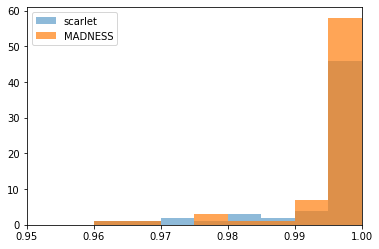

In [22]:
bins = np.arange(.95, 1, .005)
plt.hist(scarlet_cov, bins=bins, alpha=0.5, label="scarlet");
plt.hist(madness_cov, bins=bins, alpha=0.7, label="MADNESS");
plt.legend()
plt.xlim([.95, 1])

In [23]:
scarlet_actual_flux = np.array(scarlet_actual_flux)
scarlet_predicted_flux = np.array(scarlet_predicted_flux)

scarlet_relative_difference= np.divide(scarlet_predicted_flux - scarlet_actual_flux, scarlet_actual_flux)

In [24]:
madness_actual_flux = np.array(madness_actual_flux)
madness_predicted_flux = np.array(madness_predicted_flux)

madness_relative_difference= np.divide(madness_predicted_flux - madness_actual_flux, madness_actual_flux)

In [25]:
scarlet_relative_difference[np.logical_not(np.isnan(scarlet_relative_difference))].reshape(-1)

array([ 9.84369148e-02,  9.76423645e-02,  6.60713964e-02,  8.62732083e-02,
        4.31097443e-02,  1.95971585e-01, -9.59188788e-03,  1.57482325e-02,
       -3.07902396e-02, -9.19058124e-02, -4.67707482e-02, -6.11131194e-02,
        1.25261933e+01,  1.03137139e+01,  9.76199765e+00,  9.58583834e+00,
        1.09415935e+01,  8.97688370e+00,  1.23885698e-01,  3.82267321e-02,
        6.40621494e-02,  8.06421931e-02,  5.95475864e-02, -1.66804856e-01,
        9.04039080e-03,  4.39073338e-02,  1.85648860e-02, -2.74523533e-02,
        7.78016667e-02, -2.31443649e-02,  1.01238095e-01,  1.33325698e-01,
        1.08641196e-01,  1.23345176e-01,  6.60052733e-02,  1.32031455e-01,
       -8.07388457e-02, -1.83473677e-01, -1.18779205e-01, -1.35287997e-02,
       -2.08189415e-01, -8.33528567e-02,  8.13374403e+00,  8.17091562e+00,
        8.21381342e+00,  7.80427949e+00,  7.79764417e+00,  7.84771655e+00,
       -1.59825826e-01, -1.60606090e-01, -1.62323636e-01, -1.59395119e-01,
       -1.59286159e-01, -

In [26]:
np.array_equal(madness_actual_flux, scarlet_actual_flux)

True

In [27]:
from scipy.optimize import curve_fit
def gauss(x, sig, mu):
    return 1/np.sqrt(2.*np.pi)/sig*np.exp(-0.5*(x-mu)**2/sig**2)

n_bins=100
hist, bin_tmp = np.histogram(madness_relative_difference, n_bins, density=True)
bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
madness_fit = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins)])

hist, bin_tmp = np.histogram(scarlet_relative_difference, n_bins, density=True)
bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
scarlet_fit = curve_fit(gauss, bins, hist, p0=[np.std(bins), np.mean(bins)])

In [28]:
madness_fit

(array([ 0.10616617, -0.02168849]),
 array([[2.85198852e-06, 8.18221390e-07],
        [8.18221390e-07, 1.23400323e-05]]))

In [29]:
bins

array([-0.86694607, -0.60083822, -0.33473037, -0.06862251,  0.19748534,
        0.46359319,  0.72970105,  0.9958089 ,  1.26191675,  1.52802461,
        1.79413246,  2.06024031,  2.32634817,  2.59245602,  2.85856387,
        3.12467173,  3.39077958,  3.65688743,  3.92299529,  4.18910314,
        4.45521099,  4.72131885,  4.9874267 ,  5.25353455,  5.51964241,
        5.78575026,  6.05185811,  6.31796597,  6.58407382,  6.85018167,
        7.11628952,  7.38239738,  7.64850523,  7.91461308,  8.18072094,
        8.44682879,  8.71293664,  8.9790445 ,  9.24515235,  9.5112602 ,
        9.77736806, 10.04347591, 10.30958376, 10.57569162, 10.84179947,
       11.10790732, 11.37401518, 11.64012303, 11.90623088, 12.17233874,
       12.43844659, 12.70455444, 12.9706623 , 13.23677015, 13.502878  ,
       13.76898586, 14.03509371, 14.30120156, 14.56730942, 14.83341727,
       15.09952512, 15.36563298, 15.63174083, 15.89784868, 16.16395654,
       16.43006439, 16.69617224, 16.9622801 , 17.22838795, 17.49

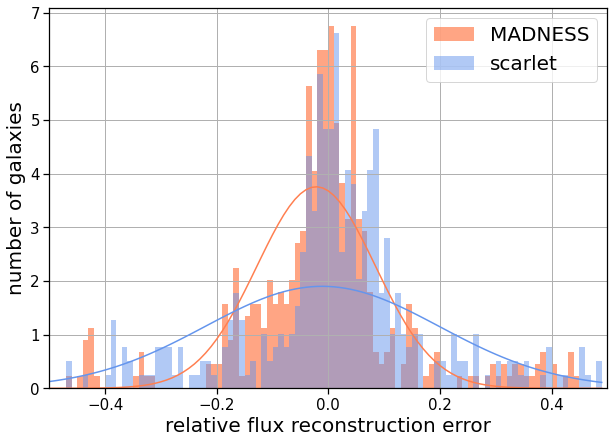

In [30]:
import seaborn as sns
from scipy.stats import norm
#print(madness_relative_difference[np.logical_not(np.isinf(madness_relative_difference))].reshape(-1))
sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'black',
                     'figure.facecolor': '1',
                     'xtick.color': 'black',
                     'ytick.color': 'black',
                     'text.color': 'black',
                     'image.cmap': 'viridis',})
plt.figure(figsize=(10,7))
bins = np.arange(-.5,.5, .01)
plt.hist(madness_relative_difference[np.logical_not(np.isnan(madness_relative_difference))].reshape(-1), bins=bins, density=True, alpha=0.7, color="coral", label="MADNESS");
plt.plot(bins, norm.pdf(bins, madness_fit[0][1], madness_fit[0][0]), color="coral")
plt.hist(scarlet_relative_difference[np.logical_not(np.isnan(scarlet_relative_difference))].reshape(-1), bins=bins, density=True, alpha=0.5, color="cornflowerblue", label="scarlet");
plt.plot(bins, norm.pdf(bins, scarlet_fit[0][1], scarlet_fit[0][0]), color="cornflowerblue")
plt.legend(fontsize=20)
ax=plt.gca()
plt.xlabel("relative flux reconstruction error", fontsize=20)
ax.tick_params(labelsize=15)
plt.ylabel("number of galaxies", fontsize=20)
plt.xlim([-.5,.5])
plt.savefig("flux_err", transparent=True)

In [31]:
print(np.amax(scarlet_relative_difference[np.logical_not(np.isnan(scarlet_relative_difference))]))
print(np.amin(scarlet_relative_difference[np.logical_not(np.isnan(scarlet_relative_difference))]))

25.610785327299343
-1.0


In [32]:
print(np.amax(madness_relative_difference[np.logical_not(np.isnan(madness_relative_difference))]))
print(np.amin(madness_relative_difference[np.logical_not(np.isnan(madness_relative_difference))]))

17.705827852151472
-0.4689399593580199


# Compute Apperture photometry

In [33]:
from maddeb.metrics import compute_apperture_photometry

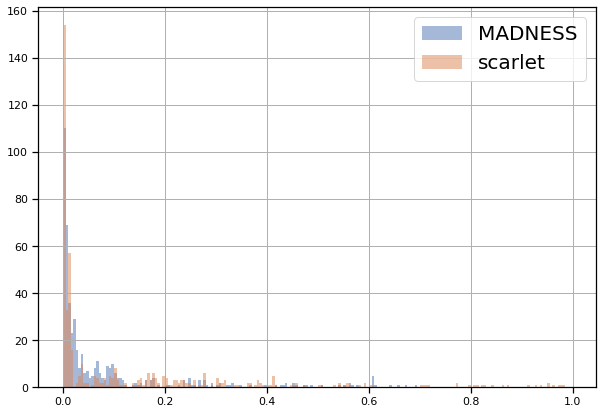

In [34]:
actual_residual_field = blend["blend_images"][0]
scarlet_residual_field = blend["blend_images"][0]

for i in range(len(scarlet_predictions[0])):
    actual_residual_field = actual_residual_field - blend["isolated_images"][0][i]
    scarlet_residual_field = scarlet_residual_field - scarlet_predictions[0][i]

padding_infos = deb.get_padding_infos()
madness_residual_field = deb.compute_residual(
    blend["blend_images"][0], use_scatter_and_sub=True
).numpy()

bkg_rms = {}
for band in range(6):
    bkg_rms[band] = sep.Background(blend["blend_images"][0][band]).globalrms

actual_gal_fluxes, actual_gal_fluxerrs, actual_gal_flags = compute_apperture_photometry(
    residual_field=actual_residual_field,
    predictions=blend["isolated_images"][0],
    xpos=blend["blend_list"][0]["x_peak"],
    ypos=blend["blend_list"][0]["y_peak"],
    bkg_rms=bkg_rms,
)

(
    madness_gal_fluxes,
    madness_gal_fluxerrs,
    madness_gal_flags,
) = compute_apperture_photometry(
    residual_field=np.transpose(madness_residual_field,  axes=(2, 0, 1)),
    predictions=madness_predictions[0],
    xpos=blend["blend_list"][0]["x_peak"],
    ypos=blend["blend_list"][0]["y_peak"],
    bkg_rms=bkg_rms,
)

(
    scarlet_gal_fluxes,
    scarlet_gal_fluxerrs,
    scarlet_gal_flags,
) = compute_apperture_photometry(
    residual_field=scarlet_residual_field,
    predictions=scarlet_predictions[0],
    xpos=blend["blend_list"][0]["x_peak"],
    ypos=blend["blend_list"][0]["y_peak"],
    bkg_rms=bkg_rms,
)

plt.figure(figsize=(10, 7))
bins = np.arange(0, 1, 0.005)
plt.hist(
    np.abs((madness_gal_fluxes - actual_gal_fluxes) / actual_gal_fluxes),
    bins=bins,
    alpha=0.5,
    label="MADNESS",
)

plt.hist(
    np.abs((scarlet_gal_fluxes - actual_gal_fluxes) / actual_gal_fluxes),
    bins=bins,
    alpha=0.5,
    label="scarlet",
)

plt.legend(fontsize=20)

plt.savefig("aperturephoto")
